In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

#Load & sort
df = pd.read_csv(
    "../data_clean/processed_data_with_features.csv",
    parse_dates=["DATETIME"]
)
df = df.sort_values(["SYMBOL", "DATETIME"]).reset_index(drop=True)

#Encode day‐of‐week as integer 0–6
df["DAY_OF_THE_WEEK"] = df["DATETIME"].dt.dayofweek

#Define feature list + target
FEATURES = [
    "DAY_OF_THE_WEEK", "HOUR_OF_DAY",
    "vol_20",   "vol_60",   "sr_20",      "mean_20",
    "zscore_20","zscore_60",
    "log_momentum_20", "log_momentum_60",
    "bb_upper_20",     "bb_lower_20",     "mdd_20",
    "ema_12", "ema_26", "macd", "macd_signal", "macd_hist"
]
TARGET = "LOG_RETURN"

#Drop only rows missing any of the chosen features or the target
df = df.dropna(subset=FEATURES + [TARGET])

#Assemble X (predictors) and y (target)
X = df[FEATURES]
y = df[TARGET]

#Chronological 80/20 split per symbol
train_idx, test_idx = [], []
for sym, grp in df.groupby("SYMBOL", sort=False):
    cut = int(len(grp) * 0.8)
    train_idx += grp.index[:cut].tolist()
    test_idx  += grp.index[cut:].tolist()

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]

symbols = df["SYMBOL"]
symbols_train = symbols.loc[train_idx].values   # not used by the GBM
symbols_test  = symbols.loc[test_idx].values    # only used for evaluation


#Fit the GradientBoostingRegressor
model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model.fit(X_train, y_train)

#Evaluate
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² :", r2_score(y_test, y_pred))


MSE: 2.7354868502439182e-06
R² : 0.3123282285275514


Test MSE        : 2.735487e-06
Pearson r       : 0.5640
Dir. Accuracy   : 60.43%

Top 10 stocks by correlation:


,MSE,Corr,Accuracy
DXCM,0.000005,0.786335,0.660256
BA,0.000003,0.753874,0.557692
WDC,0.000008,0.753259,0.634615
CCL,0.000013,0.750190,0.641026
USB,0.000002,0.748174,0.583333
PFG,0.000009,0.737992,0.615385
AIG,0.000002,0.737696,0.628205
HST,0.000007,0.735863,0.634615
DIS,0.000002,0.716579,0.673077
KR,0.000003,0.714539,0.525641



Bottom 10 stocks by correlation:


,MSE,Corr,Accuracy
AMCR,1.808892e-06,0.362145,0.480769
VRTX,1.650901e-06,0.356239,0.641026
PSA,1.740678e-06,0.349903,0.641026
IT,2.686769e-06,0.327523,0.660256
DPZ,1.942648e-06,0.306453,0.602564
DLR,1.205727e-06,0.305497,0.551282
PLD,1.972322e-06,0.288300,0.634615
ZBRA,4.769185e-06,0.256005,0.602564
COR,6.061061e-08,0.222192,0.584000
TPL,7.461251e-05,0.141558,0.555556


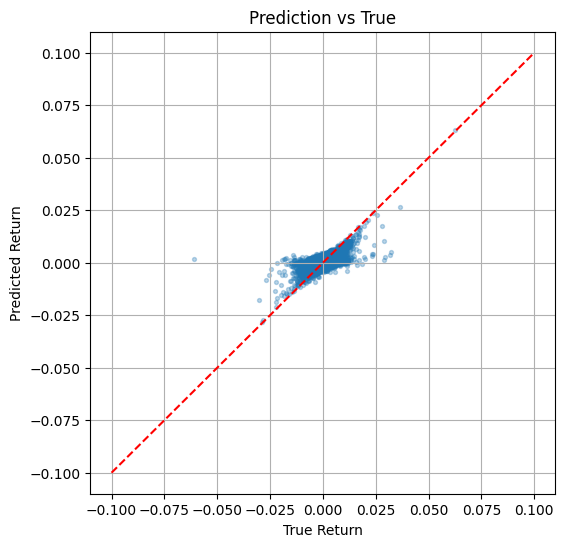

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- assume you already have:
#    y_test, y_pred, symbols_test  (symbols_test = df['SYMBOL'].loc[test_idx].values)

# 1) Overall metrics
mse_global = mean_squared_error(y_test, y_pred)
corr_global = np.corrcoef(y_pred, y_test)[0, 1]
dir_acc = np.mean((y_pred > 0) == (y_test > 0))

print(f"Test MSE        : {mse_global:.6e}")
print(f"Pearson r       : {corr_global:.4f}")
print(f"Dir. Accuracy   : {dir_acc:.2%}")

# 2) Per-ticker metrics
mse_by_stock, corr_by_stock, acc_by_stock = {}, {}, {}

for sym in np.unique(symbols_test):
    mask = (symbols_test == sym)
    yt = y_test[mask]
    yp = y_pred[mask]
    if len(yt) < 5:
        continue  # skip tiny samples

    mse_by_stock[sym]  = mean_squared_error(yt, yp)
    corr_by_stock[sym] = (
        np.corrcoef(yt, yp)[0,1] if np.std(yt) > 0 else np.nan
    )
    acc_by_stock[sym]  = np.mean((yp > 0) == (yt > 0))

results_df = pd.DataFrame({
    "MSE":    mse_by_stock,
    "Corr":   corr_by_stock,
    "Accuracy": acc_by_stock
}).sort_values("Corr", ascending=False)

print("\nTop 10 stocks by correlation:")
display(results_df.head(10))

print("\nBottom 10 stocks by correlation:")
display(results_df.tail(10))

# 3) Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3, s=8)
plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--')
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.title("Prediction vs True")
plt.grid(True)
plt.show()



Test period covers 9 days: [datetime.date(2021, 12, 20) datetime.date(2021, 12, 21)
 datetime.date(2021, 12, 22) datetime.date(2021, 12, 23)
 datetime.date(2021, 12, 27) datetime.date(2021, 12, 28)
 datetime.date(2021, 12, 29) datetime.date(2021, 12, 30)
 datetime.date(2021, 12, 31)]

Daily Sharpe: insufficient variation (std=0) → cannot compute.

Max Drawdown    : -0.94%
Intraday Sharpe : 31.02


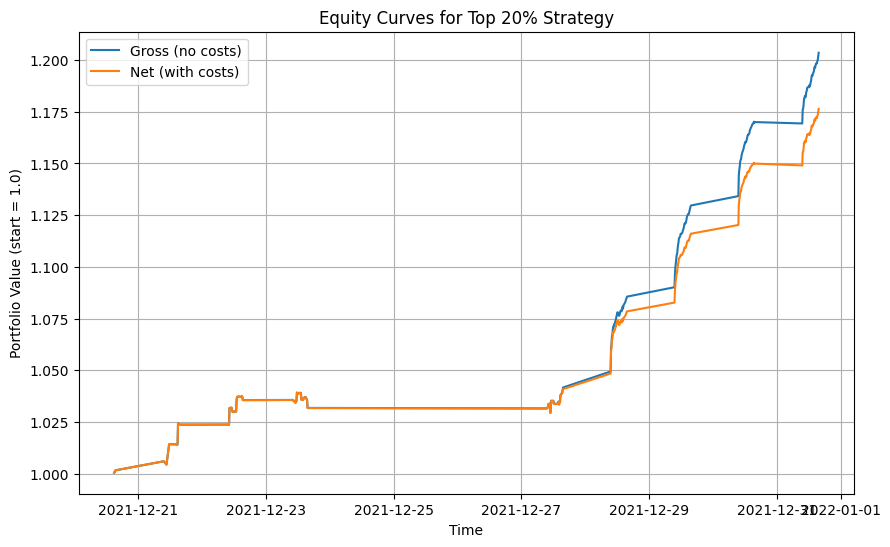

In [ ]:
# Rebuild the test DataFrame with timestamps, tickers, model predictions, and true log-returns
test_df = pd.DataFrame({
    "DATETIME":   df.loc[test_idx, "DATETIME"].values,
    "SYMBOL":     df.loc[test_idx, "SYMBOL"].values,
    "y_pred":     y_pred,
    "LOG_RETURN": y_test.values
}).sort_values("DATETIME")

# Determine the 80th percentile of predicted returns at each bar,
# then go long (signal=1) on those at or above that threshold
quantile = 0.20
thresholds = (
    test_df
      .groupby("DATETIME")["y_pred"]
      .transform(lambda x: x.quantile(1 - quantile))
)
test_df["signal"] = (test_df["y_pred"] >= thresholds).astype(int)

# Function to compute the average actual log-return of the longs at each bar
def bar_log_return(grp):
    longs = grp.loc[grp["signal"] == 1, "LOG_RETURN"]
    return longs.mean() if len(longs) else 0.0

# Apply that to get a time series of the strategy’s gross log-returns
portf = (
    test_df
      .groupby("DATETIME")
      .apply(bar_log_return)
      .rename("portfolio_logret")
)

# Build a wide signal matrix (rows=bars, cols=stocks) to measure turnover
signals_wide = test_df.pivot(index="DATETIME", columns="SYMBOL", values="signal").fillna(0)
turnover     = signals_wide.diff().abs().sum(axis=1) / signals_wide.shape[1]

# Subtract a flat transaction cost (0.1% round-trip) proportional to turnover (testing how T-costs would affect the strategy)
tc_rate   = 0.001
portf_net = portf - turnover * tc_rate

# Convert cumulative log-returns into equity curves
cum_gross = np.exp(portf.cumsum())
cum_net   = np.exp(portf_net.cumsum())

# Calculate intraday-annualized Sharpe ratio
n_days          = test_df["DATETIME"].dt.date.nunique()
bars_per_day    = len(portf_net) / n_days
ann_factor      = np.sqrt(252 * bars_per_day)
sharpe_intraday = (portf_net.mean() / portf_net.std()) * ann_factor

# Print how many unique days are in your test period
test_dates = test_df["DATETIME"].dt.date.unique()
print(f"Test period covers {len(test_dates)} days: {test_dates}\n")

# Aggregate intraday log-returns into daily buckets
daily_logret = portf_net.groupby(test_df["DATETIME"].dt.date).sum()

# Compute daily Sharpe if there’s enough variation
if daily_logret.std() == 0 or len(daily_logret) < 2:
    print("Daily Sharpe: insufficient variation (std=0) → cannot compute.\n")
else:
    daily_sharpe = (daily_logret.mean() / daily_logret.std()) * np.sqrt(252)
    print(f"Daily Sharpe Ratio : {daily_sharpe:.2f}\n")

# Calculate maximum drawdown on the net equity curve
running_max = cum_net.cummax()
max_drawdown = (cum_net / running_max - 1).min()

print(f"Max Drawdown    : {max_drawdown:.2%}")
print(f"Intraday Sharpe : {sharpe_intraday:.2f}")

# Plot gross vs. net equity
plt.figure(figsize=(10,6))
plt.plot(cum_gross, label="Gross (no costs)")
plt.plot(cum_net,   label="Net (with costs)")
plt.title("Equity Curves for Top 20% Strategy")
plt.xlabel("Time")
plt.ylabel("Portfolio Value (start = 1.0)")
plt.legend()
plt.grid(True)
plt.show()
